### load in modules

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors
import math


### load in country-population data

In [2]:
pop_df = pd.read_csv('OWID_population_data.csv', sep=',')
pop_df = pop_df[pop_df.Year == 2021]
pop_df = pop_df.rename(columns={
    'Entity': 'country',
    'Code': 'iso3',
    'Year': 'year',
    'Population (historical estimates)': 'population'
})
pop_df


,country,iso3,year,population
258,Afghanistan,AFG,2021,40099460
517,Africa,NaN,2021,1393676724
589,Africa (UN),NaN,2021,1393676416
848,Albania,ALB,2021,2854710
1107,Algeria,DZA,2021,44177964
...,...,...,...,...
56681,Western Sahara,ESH,2021,565590
56940,World,OWID_WRL,2021,7909295104
57199,Yemen,YEM,2021,32981644
57458,Zambia,ZMB,2021,19473132


### load in IDP data

In [3]:
idp_df = pd.read_csv('IDMC_Internal_Displacement_Disasters_Events_2008_2021.csv', sep=',')
idp_df = idp_df.rename(columns={
    'ISO3': 'iso3',
    'Name': 'country',
    'Year': 'year',
    'Start Date': 'date',
    'Event Name': 'event',
    'Hazard Category': 'hazard',
    'Hazard Type': 'disaster',
    'Internal Displacements': 'idp'
})


In [4]:
idp_df['date_dt'] = idp_df.date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
idp_df


,iso3,country,year,date,event,hazard,disaster,idp,date_dt
0,AB9,Abyei Area,2018,2018-07-01,Abyie: Flood - 01/07/2018,Weather related,Flood,2.0,2018-07-01
1,AB9,Abyei Area,2019,2019-06-01,Abyei: Flood - southern parts - 01/06/2019,Weather related,Flood,40000.0,2019-06-01
2,AFG,Afghanistan,2008,2008-01-01,NaN,Weather related,Extreme temperature,NaN,2008-01-01
3,AFG,Afghanistan,2008,2008-04-17,NaN,Geophysical,Earthquake,3250.0,2008-04-17
4,AFG,Afghanistan,2008,2008-08-01,NaN,Weather related,Flood,180.0,2008-08-01
...,...,...,...,...,...,...,...,...,...
11726,ZWE,Zimbabwe,2021,2021-01-19,"Madagascar, Mozambique; Zimbabwe; South Africa...",Weather related,Storm,1125.0,2021-01-19
11727,ZWE,Zimbabwe,2021,2021-11-01,Zimbabwe: Hailstorm - Manicaland (Mutare Rural...,Weather related,Storm,328.0,2021-11-01
11728,ZWE,Zimbabwe,2021,2021-01-19,"Madagascar, Mozambique; Zimbabwe; South Africa...",Weather related,Storm,265.0,2021-01-19
11729,ZWE,Zimbabwe,2021,2021-01-19,"Madagascar, Mozambique; Zimbabwe; South Africa...",Weather related,Storm,140.0,2021-01-19


In [5]:
## remove NaN
idp_df_noNA = idp_df[~idp_df.disaster.isna()].copy()
idp_df_noNA.disaster = idp_df_noNA.disaster.apply(lambda x: x.lower())
idp_df_noNA.hazard = idp_df_noNA.hazard.apply(lambda x: x.lower())


### load in shapefile

In [6]:
gdf = gpd.read_file('./World_Countries_(Generalized)/World_Countries__Generalized_.shp')
gdf


,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry
0,1,Afghanistan,AF,Afghanistan,AF,50.803210,62.566714,"POLYGON ((61.27655 35.60725, 61.29638 35.62854..."
1,2,Albania,AL,Albania,AL,9.625038,3.073540,"POLYGON ((19.57083 41.68527, 19.58195 41.69569..."
2,3,Algeria,DZ,Algeria,DZ,70.540082,213.513461,"POLYGON ((4.60335 36.88791, 4.63555 36.88638, ..."
3,4,American Samoa,AS,United States,US,0.600124,0.013720,"POLYGON ((-170.74390 -14.37555, -170.74942 -14..."
4,5,Andorra,AD,Andorra,AD,0.937352,0.055585,"POLYGON ((1.44584 42.60194, 1.48653 42.65042, ..."
...,...,...,...,...,...,...,...,...
246,247,Vietnam,VN,Viet Nam,VN,66.866802,27.556082,"MULTIPOLYGON (((107.07896 17.10804, 107.08333 ..."
247,248,Wallis and Futuna,WF,France,FR,0.700608,0.013414,"MULTIPOLYGON (((-178.06082 -14.32389, -178.137..."
248,249,Yemen,YE,Yemen,YE,34.011327,38.289871,"MULTIPOLYGON (((47.25445 13.61528, 47.16888 13..."
249,250,Zambia,ZM,Zambia,ZM,49.141439,62.814022,"POLYGON ((30.21302 -14.98172, 30.21916 -15.096..."


### Check IDP-population ISO-3 consistency

In [7]:
## read in iso2 to iso3 mapping
iso23 = pd.read_csv('iso2-3_map.csv', sep='\t')
iso23.ISO2 = iso23.ISO2.apply(lambda x: 'NA' if not isinstance(x, str) and math.isnan(x) else x)
iso23_dict = dict(zip(iso23.ISO2.values, iso23.ISO3.values))

## add iso3 to dataframe
gdf['iso3'] = gdf.ISO.apply(lambda x: iso23_dict[x] if x in iso23_dict else np.nan)


In [10]:
## check ISO-3 consistency
set(idp_df_noNA.iso3.unique()) - set(gdf.iso3.unique())

## map AB9 to SDN
## map HKG, MAC, TWN to CHN
## ignore XKX (Kosovo)
idp_df_noNA_ISO3_fixed = idp_df_noNA.copy()
idp_df_noNA_ISO3_fixed.iso3 = idp_df_noNA_ISO3_fixed.iso3.apply(lambda x: 'SDN' if x == 'AB9' else x)
idp_df_noNA_ISO3_fixed.iso3 = idp_df_noNA_ISO3_fixed.iso3.apply(lambda x: 'CHN' if x in ['HKG', 'MAC', 'TWN'] else x)


### Map population data to idp_df_noNA_ISO3_fixed

In [12]:
idp_df_noNA_ISO3_fixed = idp_df_noNA_ISO3_fixed.merge(pop_df[['iso3', 'population']], on='iso3')


### Process IDP data

#### IDPs

In [14]:
## count IDPs
idp_df_noNA_idps_year = idp_df_noNA_ISO3_fixed.copy()

## group mass movement
idp_df_noNA_idps_year.disaster = idp_df_noNA_idps_year.disaster.apply(
    lambda x: 'mass movement' if 'mass movement' in x else x)

## group by country, year and disaster
idp_df_noNA_idps_year = idp_df_noNA_idps_year[
    (idp_df_noNA_idps_year.hazard == 'weather related') & (~idp_df_noNA_idps_year.idp.isna())].groupby(
    ['iso3', 'year', 'disaster', 'population']).agg({'idp': 'sum'}).reset_index()

idp_df_noNA_idps_year


,iso3,year,disaster,population,idp
0,AFG,2008,flood,40099460,180.0
1,AFG,2009,flood,40099460,25185.0
2,AFG,2010,flood,40099460,70000.0
3,AFG,2011,flood,40099460,3000.0
4,AFG,2012,extreme temperature,40099460,3007.0
...,...,...,...,...,...
2334,ZWE,2019,flood,15993525,200.0
2335,ZWE,2019,storm,15993525,52105.0
2336,ZWE,2020,flood,15993525,183.0
2337,ZWE,2020,storm,15993525,200.0


In [15]:
## aggregate over all years
idp_type_count = idp_df_noNA_idps_year.groupby(
    ['iso3', 'disaster', 'population']).agg({'idp': 'sum'}).reset_index()
idp_type_count['idp_p'] = idp_type_count.apply(lambda row: row.idp/row.population, axis=1)
idp_type_count['idp_1000p'] = idp_type_count.apply(lambda row: row.idp*1000/row.population, axis=1)
idp_type_count


,iso3,disaster,population,idp,idp_p,idp_1000p
0,AFG,drought,40099460,378534.0,9.439878e-03,9.439878
1,AFG,extreme temperature,40099460,8197.0,2.044167e-04,0.204417
2,AFG,flood,40099460,404213.0,1.008026e-02,10.080260
3,AFG,mass movement,40099460,22278.0,5.555686e-04,0.555569
4,AFG,storm,40099460,396.0,9.875445e-06,0.009875
...,...,...,...,...,...,...
519,ZMB,storm,19473132,461.0,2.367364e-05,0.023674
520,ZWE,flood,15993525,73175.0,4.575289e-03,4.575289
521,ZWE,mass movement,15993525,12.0,7.503036e-07,0.000750
522,ZWE,storm,15993525,60692.0,3.794786e-03,3.794786


In [16]:
## aggregate over all events (but individual years)
idp_year_count = idp_df_noNA_idps_year.groupby(
    ['iso3', 'year', 'population']).agg({'idp': 'sum'}).reset_index()
idp_year_count['idp_p'] = idp_year_count.apply(lambda row: row.idp/row.population, axis=1)
idp_year_count['idp_1000p'] = idp_year_count.apply(lambda row: row.idp*1000/row.population, axis=1)
idp_year_count


,iso3,year,population,idp,idp_p,idp_1000p
0,AFG,2008,40099460,180.0,0.000004,0.004489
1,AFG,2009,40099460,25185.0,0.000628,0.628063
2,AFG,2010,40099460,70000.0,0.001746,1.745659
3,AFG,2011,40099460,3000.0,0.000075,0.074814
4,AFG,2012,40099460,24437.0,0.000609,0.609410
...,...,...,...,...,...,...
1426,ZWE,2017,15993525,10270.0,0.000642,0.642135
1427,ZWE,2018,15993525,1064.0,0.000067,0.066527
1428,ZWE,2019,15993525,52305.0,0.003270,3.270386
1429,ZWE,2020,15993525,383.0,0.000024,0.023947


In [17]:
## aggregate over all events and years
idp_total_count = idp_df_noNA_idps_year.groupby(
    ['iso3', 'population']).agg({'idp': 'sum'}).reset_index()
idp_total_count['idp_p'] = idp_total_count.apply(lambda row: row.idp/row.population, axis=1)
idp_total_count['idp_1000p'] = idp_total_count.apply(lambda row: row.idp*1000/row.population, axis=1)
idp_total_count


,iso3,population,idp,idp_p,idp_1000p
0,AFG,40099460,813618.0,0.020290,20.289999
1,AGO,34503776,494339.0,0.014327,14.327099
2,AIA,15779,500.0,0.031688,31.687686
3,ALB,2854710,11587.0,0.004059,4.058906
4,ARE,9365149,1670.0,0.000178,0.178321
...,...,...,...,...,...
192,WSM,218781,9235.0,0.042211,42.211161
193,YEM,32981644,518013.0,0.015706,15.706100
194,ZAF,59392256,146208.0,0.002462,2.461735
195,ZMB,19473132,102897.0,0.005284,5.284050


### Make plots

#### Total IDPs (per 1000)

In [18]:
## colouring parameters
norm = plt.Normalize(-2,2)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#5a9bab', '#b55454'])


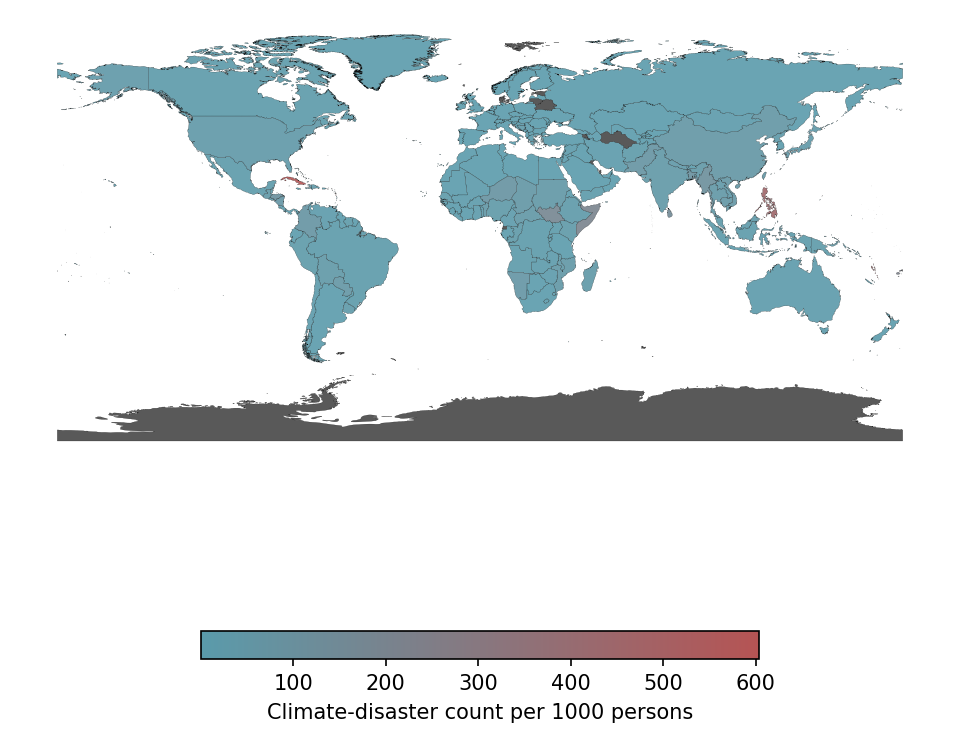

In [19]:
w = 8; h = 10
fig, ax = plt.subplots(figsize=(w,h), dpi=150)

plot_df = gdf.merge(idp_total_count, on='iso3', how='left')
plot_df.plot(column='idp_1000p', ax=ax, legend=True, cmap=cmap, alpha=0.9,
             edgecolor='black', linewidth=0.1,
             legend_kwds={
                 'label': "Climate-disaster count per 1000 persons",
                 'orientation': "horizontal",
                 'shrink': 0.6},
             missing_kwds={ "color": "#484848", "alpha": 0.9 }
            )

ax.axis('off')
plt.show()

fig.savefig('./figures/total_idp_counts_per_1000.pdf', dpi=250)


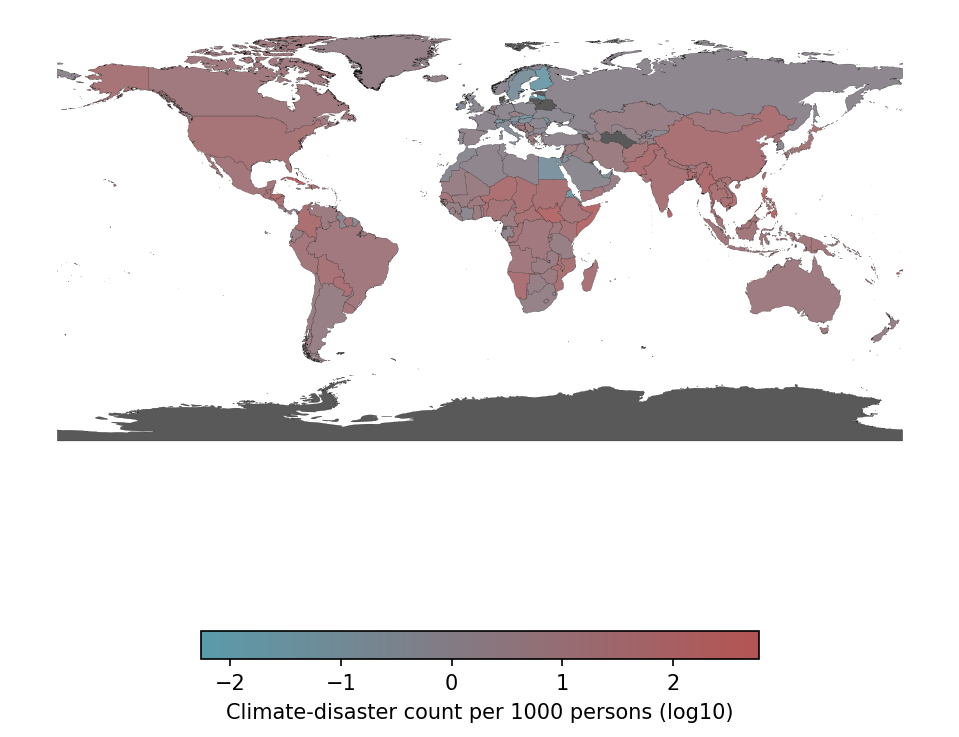

In [20]:
w = 8; h = 10
fig, ax = plt.subplots(figsize=(w,h), dpi=150)

plot_df = gdf.merge(idp_total_count, on='iso3', how='left')
plot_df.idp_1000p = plot_df.idp_1000p.apply(lambda x: np.log10(x))
plot_df.plot(column='idp_1000p', ax=ax, legend=True, cmap=cmap, alpha=0.9,
             edgecolor='black', linewidth=0.1,
             legend_kwds={
                 'label': "Climate-disaster count per 1000 persons (log10)",
                 'orientation': "horizontal",
                 'shrink': 0.6},
             missing_kwds={ "color": "#484848", "alpha": 0.9 }
            )

ax.axis('off')
plt.show()

fig.savefig('./figures/total_idp_counts_per_1000_log10.pdf', dpi=250)
